In [143]:
import pandas as pd
import numpy as np
from astropy.io import fits

from highz_qso_arxiv.util import mjd_to_unix
from highz_qso_arxiv.util.photutil import find_peak, get_mosfire_acq, get_mosfire_acq_proc, circle_mask, naive_bkg_subtract, sigma_clipping_bkg_subtract
from highz_qso_arxiv.crawler import get_skyprobe_extinction
from highz_qso_arxiv.resource.zero_points import mosfire_ZP
from highz_qso_arxiv.plot import plot_acq_and_hist, plot_extinction

from pypeit.scripts import view_fits

path = "../arxiv/MOSFIRE_2204/raw"
df = pd.read_csv('offset_list.csv')

In [ ]:
m_aper = []
for i in range(len(df)):

    vf = view_fits.ViewFits()
    args = vf.get_parser()
    args.proc = True
    args.det = [1]
    args.file = "{}/m220409_{}.fits".format(path, "%04d"%df["objframe"][i])
    args.bkg_file = "{}/m220409_{}.fits".format(path, "%04d"%df["skyframe"][i])
    acq_img = get_mosfire_acq_proc(path, objfile="m220409_{}.fits".format("%04d"%df["objframe"][i]), 
                                   skyfile="m220409_{}.fits".format("%04d"%df["skyframe"][i]))
    hdr = fits.getheader("{}/m220409_{}.fits".format(path, "%04d"%df["objframe"][i]))
    peak = find_peak(acq_img)
    # plot_acq_and_hist(acq_img, peak, title=df["offset"][i], display=True, save_file=f"{df["offset"][i]}.pdf")

    mask = circle_mask(acq_img, peak[0], peak[1], 6)
    star_medsub = naive_bkg_subtract(acq_img, method="median", mask_source=True)
    # star_sigmaclip = sigma_clipping_bkg_subtract(acq_img, mask_radius=10)

    f_star = np.sum(star_medsub[mask]) / hdr["TRUITIME"]
    # f_star = np.sum(star_sigmaclip[mask]) / hdr["TRUITIME"]

    m_star = -2.5 * np.log10(f_star) + mosfire_ZP["J"]
    print(df["offset"][i], df["JAB"][i], m_star)
    m_aper.append(m_star)
m_star = np.array(m_star)

In [141]:
m_aper = []
for i in range(len(df)):
    
    acq_img = get_mosfire_acq_proc(path, objfile="m220409_{}.fits".format("%04d"%df["objframe"][i]), 
                                   skyfile="m220409_{}.fits".format("%04d"%df["skyframe"][i]))
    hdr = fits.getheader("{}/m220409_{}.fits".format(path, "%04d"%df["objframe"][i]))
    peak = find_peak(acq_img)
    # plot_acq_and_hist(acq_img, peak, title=df["offset"][i], display=True, save_file=f"{df["offset"][i]}.pdf")

    mask = circle_mask(acq_img, peak[0], peak[1], 6)
    star_medsub = naive_bkg_subtract(acq_img, method="median", mask_source=True)
    # star_sigmaclip = sigma_clipping_bkg_subtract(acq_img, mask_radius=10)

    f_star = np.sum(star_medsub[mask]) / hdr["TRUITIME"]
    # f_star = np.sum(star_sigmaclip[mask]) / hdr["TRUITIME"]

    m_star = -2.5 * np.log10(f_star) + mosfire_ZP["J"]
    print(df["offset"][i], df["JAB"][i], m_star)
    m_aper.append(m_star)
m_star = np.array(m_star)

J0841+3814 15.0 15.327417199897637
J0951+5146 16.743875 16.074223873406325
J1003+5424 18.53792 17.865341969589565
J1124+0310 19.449362 19.903323022632417
J1150-0143 15.278945 15.599961412668073
J1202+0129 19.264778 19.537685741379512
J1218+5254 16.848807 16.28306343437047
J1318+2932 19.156647 19.387297015748537
J1315+1533 16.974504 17.24382270728089
J1333+0919 18.330868 18.70722236537027
J1332+0150 18.959614 19.16255593093478
J1511+0344 17.018526 17.392969565559916
J1424+2527 17.574005 16.41307439737048
J1544+3138 17.729967 17.073207555628652
J1447+5839 17.720618 17.34423375766163


In [126]:
extinction, scatter = [], []
for i in range(len(df)):
    hdr = fits.getheader("{}/m220409_{}.fits".format(path, "%04d"%df["objframe"][i]))
    obs_mjd = hdr["MJD-OBS"]
    obs_unix = mjd_to_unix(obs_mjd)
    extinction_data = get_skyprobe_extinction(obs_unix-900, obs_unix+900)
    closest_time = min(extinction_data["time"], key=lambda x:abs(x-obs_unix))
    dat = extinction_data[extinction_data["time"]==closest_time]
    extinction.append(dat["extinction"].value[0]-0.03)
    scatter.append(dat["scatter"].value[0])
extinction = np.array(extinction)
scatter = np.array(scatter)

No handles with labels found to put in legend.


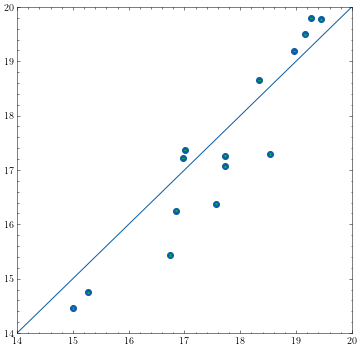

In [131]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(6,6))

ax.plot([0,20], [0,20])
# ax.scatter(df["JAB"], m_aper, label="without extinction")
ax.scatter(df["JAB"], m_aper-extinction)
ax.errorbar(df["JAB"], m_aper-extinction, yerr=scatter, linestyle='None', elinewidth=1, capsize=1, capthick=1)

# ax.scatter(df["JAB"]-m_aper, extinction)
# ax.errorbar(df["JAB"]-m_aper, extinction, yerr=scatter, linestyle='None', elinewidth=1, capsize=1, capthick=1)
ax.set_xlim(14, 20)
ax.set_ylim(14, 20)
# ax.set_xlim(-0.6, 1.3)
# ax.set_ylim(-0.6, 1.3)

ax.legend()


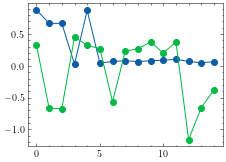

In [142]:
plt.scatter(range(len(extinction)), extinction)
plt.scatter(range(len(extinction)), m_aper-df["JAB"])

plt.plot(range(len(extinction)), extinction)
plt.plot(range(len(extinction)), m_aper-df["JAB"])